Importing packages:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,accuracy_score
from math import sqrt
import xgboost as xgb

Loading data:

In [3]:
path = '/content/drive'
drive.mount(path)

feature=pd.read_csv('/content/drive/My Drive/Walmart_project/Features_data_set.csv')
sales = pd.read_csv('/content/drive/My Drive/Walmart_project/sales_data_set.csv')
stores = pd.read_csv('/content/drive/My Drive/Walmart_project/stores_data_set.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
feature.head()
sales.head()
stores.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-12-02,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-05-03,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


Converting date to pandas format, extracting year, day, month, days to Christmas and day of the week, and merging all 3 datasets:

In [4]:
feature['Date'] = pd.to_datetime(feature['Date'])
sales['Date'] = pd.to_datetime(sales['Date'])
df = pd.merge(sales, feature, on = ['Store','Date','IsHoliday'])
df = pd.merge(df, stores, on = ['Store'], how = 'left')
# Add column for year
df["Year"] = pd.to_datetime(df["Date"], format="%Y-%m-%d").dt.year

# Add column for day
df["Day"] = pd.to_datetime(df["Date"], format="%Y-%m-%d").dt.day

# Add column for day
df["Month"] = pd.to_datetime(df["Date"], format="%Y-%m-%d").dt.month

# Add column for days to next Christmas
df["Days to Next Christmas"] = (pd.to_datetime(df["Year"].astype(str)+"-12-31", format="%Y-%m-%d") -
                                   pd.to_datetime(df["Date"], format="%Y-%m-%d")).dt.days.astype(int)
# Add column for day of the week
df['dayofweek']= pd.to_datetime(df['Date']).dt.dayofweek

# Drop the origin date column
df = df.drop(['Date'], axis= 1)

# Check the NA values Eveluation
df.isnull().sum()

# Fill NA values with zeros
df = df.fillna(0)

# Check the number of duplicated entries in the dataframe
df.duplicated().sum()

# Explore the dataset
df.head()

# Explore the distribution of types of store
df['Type'].value_counts(normalize = True)

A    0.511132
B    0.387824
C    0.101044
Name: Type, dtype: float64

In [5]:
# Convert the 'IsHoliday' from char to binary:
le = LabelEncoder()
le.fit(df.IsHoliday.drop_duplicates())
df.IsHoliday = le.transform(df.IsHoliday)

Plotting graphs:

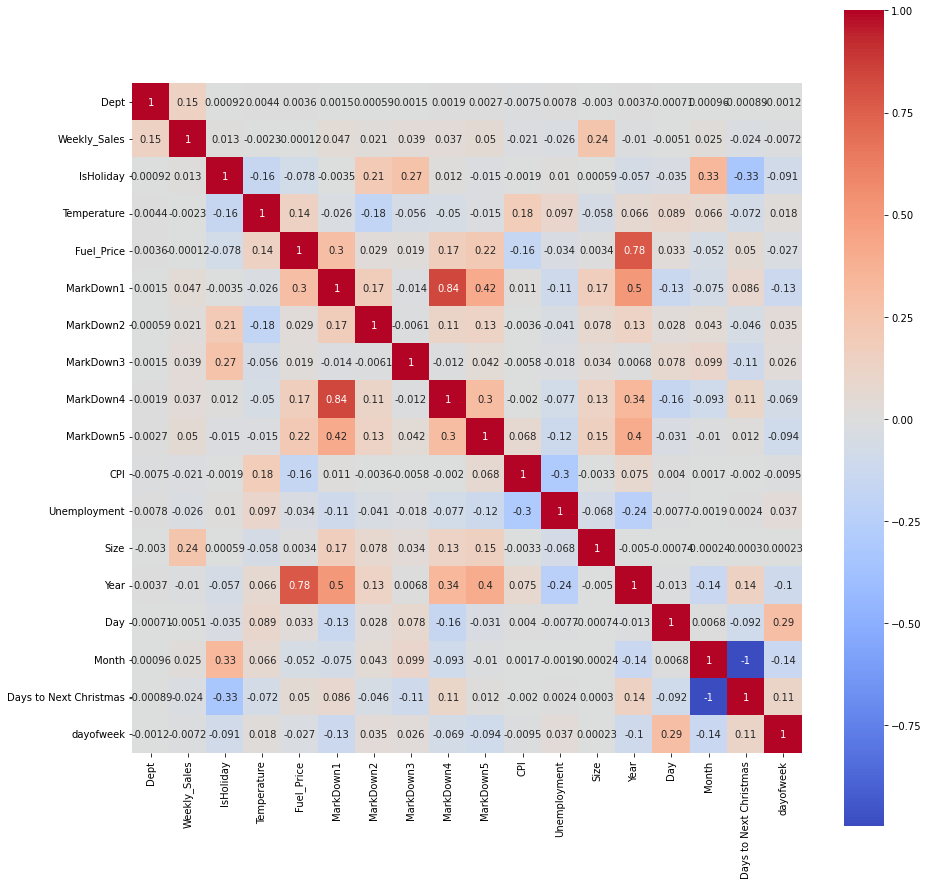

In [6]:
corr_matrix = df.drop(columns = ['Store']).corr()
plt.figure(figsize = (15,15))
sns.heatmap(corr_matrix, cmap = 'coolwarm',annot = True,square = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feaab9ebee0>,
      dtype=object)

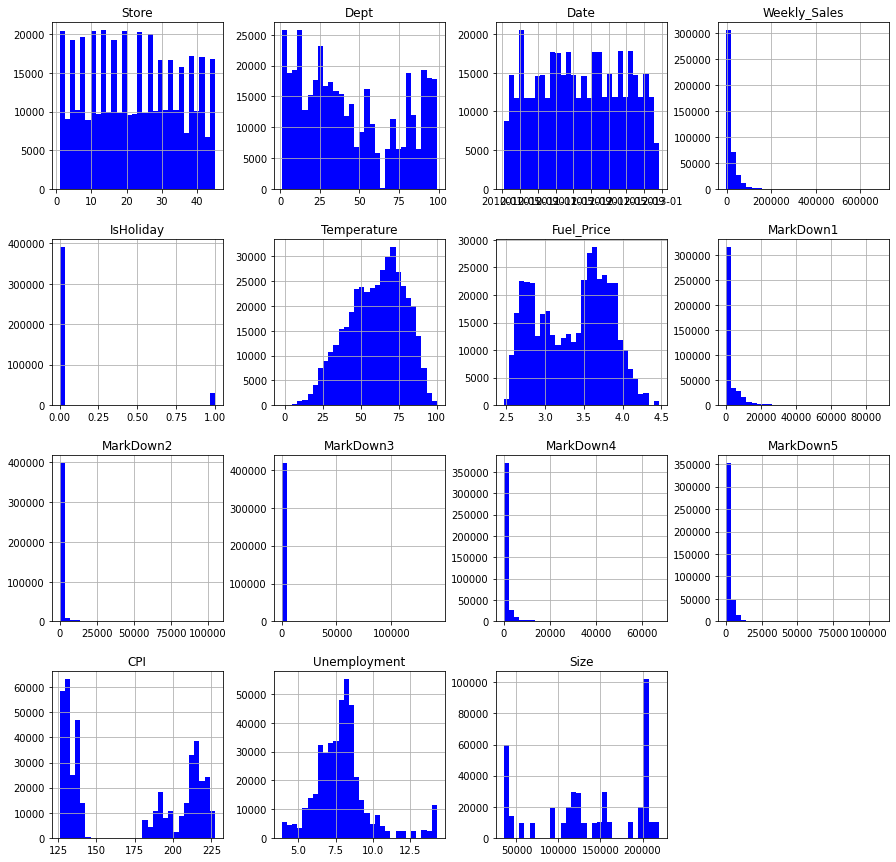

In [30]:
df.hist(bins = 30, figsize = (15,15), color = 'b')

In [7]:
df_type = df.groupby('Type').mean()
df_type

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Year,Day,Month,Days to Next Christmas,dayofweek
Type,,,,,,,,,,,,,,,,,,,
A,21.736419,44.622156,20099.568043,0.070471,60.531945,3.343999,3102.403194,1083.216159,549.644930,1325.891281,2147.830168,174.408895,7.791595,182231.285486,2010.966683,15.639040,6.480030,183.565422,3.571529
B,18.450417,43.112273,12237.075977,0.070412,57.562951,3.382523,2553.465968,827.500452,481.215226,1043.927675,1324.921913,167.176656,7.928836,101818.735827,2010.967858,15.650148,6.478100,183.613046,3.572751
C,38.942015,46.836350,9519.532538,0.069582,67.554266,3.364654,138.960203,53.274338,5.142226,5.603993,505.826631,170.429314,8.934350,40535.725286,2010.981055,15.646102,6.473085,183.772848,3.569876


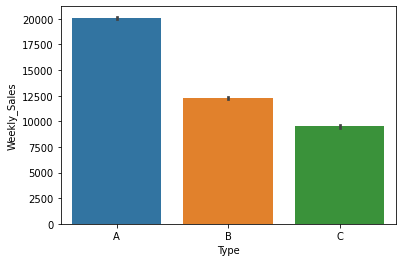

In [8]:
# Visulaze the Sales by the stores
sns.barplot(x = df['Type'], y = df['Weekly_Sales'], data = df)

Preparing data for machine learning:

In [6]:
#Split data into predictors and response and convert categorical variables into numerical and use one-hot encoding:
df_target = df['Weekly_Sales']
df_final = df.drop(columns = ['Weekly_Sales'])
df_final = pd.get_dummies(df_final, columns = ['Type','Store','Dept'], drop_first = True)

# Convert to numpy array
X = np.array(df_final).astype('float32')
y = np.array(df_target).astype('float32')

# Reshaping the array from (421570, ) to (421570, 1 )
y_reshape = y.reshape(-1,1)

#Scaling:
scaler_x = StandardScaler()
X_scale = scaler_x.fit_transform(X)
scaler_y = StandardScaler()
y_scale = scaler_y.fit_transform(y_reshape)

#Splitting data into train and test:
X_train, X_test, y_train, y_test = train_test_split(X_scale,y_scale,test_size = 0.2,random_state = 114)



Linear Regression with degree = 1:

In [7]:
#Baseline Linear Regression Model:
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_R2 = lr.score(X_test,y_test)
lr_R2





0.6561721096368058

In [23]:
# Predict the value
y_pred = lr.predict(X_test)

y_pred_orig = scaler_y.inverse_transform(y_pred)
y_test_orig = scaler_y.inverse_transform(y_test)

In [24]:
k = X_test.shape[1]
n = len(X_test)

RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_pred_orig)
MAE = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)
adj_r2 = 1 - (1-r2) * (n-1)/(n-k)

print('RMSE =',RMSE, 
      '\nMSE =',MSE, 
      '\nMAE =',MAE,
      '\nR2=',r2, 
      '\nAdjusted R2 =',adj_r2)

RMSE = 13218.366 
MSE = 174725200.0 
MAE = 8108.9443 
R2= 0.6561721205436999 
Adjusted R2 = 0.6555961602361946


Deep learning:

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [29]:
#Construct the ANN model:
ANN_model = keras.Sequential()
ANN_model.add(Dense(50, input_dim = 142))
ANN_model.add(Activation('relu'))

ANN_model.add(Dense(200))
ANN_model.add(Activation('relu'))
ANN_model.add(Dropout(0.25))

ANN_model.add(Dense(100))
ANN_model.add(Activation('linear'))

ANN_model.add(Dense(1))
ANN_model.compile(loss = 'mse', optimizer = 'adam')
ANN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                7150      
                                                                 
 activation (Activation)     (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 200)               10200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 activation_2 (Activation)   (None, 100)               0

In [35]:
# Compile the model and trainning
ANN_model.compile(optimizer= 'Adam', loss='mean_squared_error')
epochs_hist = ANN_model.fit(X_train, y_train, epochs= 20, batch_size = 1000, validation_split= 0.3)

result = ANN_model.evaluate(X_test, y_test)
accuracy_ANN = 1 - result
print('Accuracy : {}'.format(accuracy_ANN) )

Epoch 1/20
237/237 [==============================] - 7s 23ms/step - loss: 0.0532 - val_loss: 0.0589
Epoch 2/20
237/237 [==============================] - 4s 16ms/step - loss: 0.0521 - val_loss: 0.0592
Epoch 3/20
237/237 [==============================] - 4s 16ms/step - loss: 0.0518 - val_loss: 0.0566
Epoch 4/20
237/237 [==============================] - 4s 16ms/step - loss: 0.0511 - val_loss: 0.0557
Epoch 5/20
237/237 [==============================] - 4s 16ms/step - loss: 0.0512 - val_loss: 0.0565
Epoch 6/20
237/237 [==============================] - 4s 16ms/step - loss: 0.0500 - val_loss: 0.0547
Epoch 7/20
237/237 [==============================] - 4s 16ms/step - loss: 0.0498 - val_loss: 0.0571
Epoch 8/20
237/237 [==============================] - 4s 16ms/step - loss: 0.0499 - val_loss: 0.0562
Epoch 9/20
237/237 [==============================] - 5s 22ms/step - loss: 0.0492 - val_loss: 0.0552
Epoch 10/20
237/237 [==============================] - 8s 35ms/step - loss: 0.0471 - val_lo

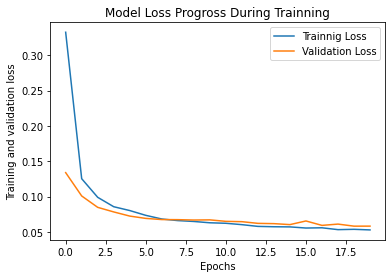

In [31]:
epochs_hist.history.keys()
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])
plt.title('Model Loss Progross During Trainning')
plt.xlabel('Epochs')
plt.ylabel('Training and validation loss')
plt.legend(['Trainnig Loss','Validation Loss'])

In [37]:
#Evaluating:
y_pred = ANN_model.predict(X_test)

y_pred_orig = scaler_y.inverse_transform(y_pred)
y_test_orig = scaler_y.inverse_transform(y_test)
k = X_test.shape[1]
n = len(X_test)

RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_pred_orig)
MAE = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)
adj_r2 = 1 - (1-r2) * (n-1)/(n-k)

print('RMSE =',RMSE, 
      '\nMSE =',MSE, 
      '\nMAE =',MAE,
      '\nR2=',r2, 
      '\nAdjusted R2 =',adj_r2)

2635/2635 [==============================] - 6s 2ms/step
RMSE = 5209.055 
MSE = 27134254.0 
MAE = 2320.4722 
R2= 0.9466046501488533 
Adjusted R2 = 0.9465152053889686


XGBoosting:

In [45]:
 #XGBoost with grid-search;
param_grid = {
        'gamma': [0.1,0.5,1],   # regularization parameter 
        'max_depth': [ 4, 5, 6] # depth of each tree
        }

xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror')

grid_xgb = GridSearchCV(xgb_model,
                    param_grid,
                    cv = 3, 
                    n_jobs = -1, 
                    verbose = 4)



In [46]:
grid_xgb.fit(X_train, y_train)
grid_xgb.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


{'gamma': 0.5, 'max_depth': 6}

In [47]:
grid_xgb_R2 = grid_xgb.score(X_test,y_test)
grid_xgb_R2

0.8483527702919769

In [56]:
grid_xgb_R2 = grid_xgb.score(X_train,y_train)
grid_xgb_R2

0.8548088511806126

In [55]:
y_pred

array([-3.2338411e-01, -7.9572201e-05, -3.1869608e-01, ...,
       -4.6790999e-01, -6.1093080e-01, -3.7230438e-01], dtype=float32)

In [ ]:
# Predict the value
y_pred = grid_xgb.predict(X_test)

y_pred_orig = scaler_y.inverse_transform(y_pred)
y_test_orig = scaler_y.inverse_transform(y_test)

In [ ]:
k = X_test.shape[1]
n = len(X_test)

RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_pred_orig)
MAE = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)
adj_r2 = 1 - (1-r2) * (n-1)/(n-k)

print('RMSE =',RMSE, 
      '\nMSE =',MSE, 
      '\nMAE =',MAE,
      '\nR2=',r2, 
      '\nAdjusted R2 =',adj_r2)

Randomforest:

In [9]:
#RandomForest with grid-search:
param_grid = {
        'max_features': [3,5,7],   # regularization parameter 
        'max_depth': [3, 4, 5, 6,7] # depth of each tree
        }

rf = RandomForestRegressor(random_state=0,verbose = 1)


grid_rf = GridSearchCV(rf,
                    param_grid,
                    cv = 3, 
                    n_jobs = -1, 
                    verbose = 4)

In [ ]:
rf.fit(X_train,y_train)

In [ ]:
rf_R2 = rf.score(X_test,y_test)
rf_R2

In [ ]:
grid_rf.fit(X_train, y_train)
grid_rf.best_params_

In [60]:
rf_R2 = grid_rf.score(X_test,y_test)
rf_R2

0.28919508785886594

In [ ]:
# Predict the value
y_pred = rf.predict(X_test)

y_pred_orig = scaler_y.inverse_transform(y_pred)
y_test_orig = scaler_y.inverse_transform(y_test)

In [ ]:
k = X_test.shape[1]
n = len(X_test)

RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_pred_orig)
MAE = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)
adj_r2 = 1 - (1-r2) * (n-1)/(n-k)

print('RMSE =',RMSE, 
      '\nMSE =',MSE, 
      '\nMAE =',MAE,
      '\nR2=',r2, 
      '\nAdjusted R2 =',adj_r2)